In [4]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
import os
from os import listdir
from os.path import isfile, join
from json import dump
import time
import pandas as pd
%matplotlib inline

In [3]:
def umat_to_mat(obj):
    return cv2.UMat.get(obj)

In [11]:
def get_metrics(path_directory, image_name, descriptor, keypoints_image_kernel, descriptors_image_kernel, 
                matcher, image_kernel, ratio=0.75):
    
    image_path = f'{path_directory}/{image_name}'
    
    print(image_path)
    metrics = {'ratio':ratio}
    
    # define start time
    time_start = time.thread_time()
    
    image = cv2.imread(image_path)
    metrics['pixels'] = image.shape[0] * image.shape[1]
    image = cv2.UMat(image)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    keypoints_image, descriptors_image = descriptor.detectAndCompute(gray,None)
        
    image_features = cv2.drawKeypoints(umat_to_mat(gray),keypoints_image,umat_to_mat(image_kernel))

    # find matches
    # print(f'type (descriptors_image_kernel) : {type(descriptors_image_kernel)}\n type (descriptors_image): {type(descriptors_image)}')
    matches = matcher.knnMatch(descriptors_image_kernel, descriptors_image, k=2) # sift k = 2
    
    # define end time
    time_end = time.thread_time()
    metrics['thread_time'] = time_end - time_start
    
    # compute distance
    good_matches = []
    for m, n in matches:
        if m.distance < ratio * n.distance:
            good_matches.append(m)
    
    image_maches_draw = cv2.drawMatches(image_kernel, keypoints_image_kernel, image, keypoints_image, good_matches, None)
    
    metrics['matches_good_ratio'] = len(good_matches) / np.array(matches)[:,1].shape[0]
    
    localization_errors_l1 = np.array([abs(m.distance - n.distance) for m, n in matches])
    localization_errors_l2 = np.array([np.power(m.distance - n.distance, 2) for m, n in matches])
    
    metrics['localization_error_l1_mean'] = localization_errors_l1.mean()
    metrics['localization_error_l2_mean'] = localization_errors_l2.mean()
    
    return metrics, image_features, umat_to_mat(image_maches_draw)

In [10]:
def define_metrics(descriptor_name, directory_train_name, json_dump_name, name_directory_dump, ratio=0.75, saved_dump=True):
    '''
    descriptor_name - SIFT, AKAZE string format,
    directory_train_name - string format name of directory,
    json_dump_name - string format name of json_dump
    '''
    metrics_images = {}

    path_directory = os.path.abspath(os.getcwd())
    path_directory_image = f'{path_directory}/{directory_train_name}'
    
    path_features = f'{directory_train_name}_{descriptor_name}'
    path_features_compared = f'{directory_train_name}_{descriptor_name}_compared'
    try:
#         os.mkdir(path_features)
#         os.mkdir(path_features_compared)
        os.mkdir(name_directory_dump)
        
    except FileExistsError:
            pass
    
    all_training_set = np.array([f for f in listdir(path_directory_image) if isfile(join(path_directory_image, f))])
    all_training_set = np.sort(all_training_set)
    
    
    path_kernel_image = f'{path_directory_image}/{all_training_set[1]}'
    
    print(f'kernel : {path_kernel_image}')
    image_kernel = cv2.imread(path_kernel_image) 
    
    # Turn on GPU
    image_kernel = cv2.UMat(image_kernel)
    
    gray_image_kernel = cv2.cvtColor(image_kernel, cv2.COLOR_BGR2GRAY)
        
    if descriptor_name == 'sift':
        print('sift')
        descriptor = cv2.xfeatures2d.SIFT_create()
        matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
        
    elif descriptor_name == 'akaze':
        print('akaze')
        descriptor = cv2.AKAZE_create()
        matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMING)

    else:
        pass
    
    keypoints_image_kernel, descriptors_image_kernel = descriptor.detectAndCompute(gray_image_kernel,None)
    
    for image_file_name in all_training_set[2:]:

        metrics, image_features, image_maches_draw  = get_metrics(path_directory_image, image_file_name, descriptor, keypoints_image_kernel, descriptors_image_kernel,
                              matcher, image_kernel, ratio)
        metrics_images[image_file_name] = metrics
        
#         cv2.imwrite(f'{path_features}/{image_file_name}', image_features)
#         cv2.imwrite(f'{path_features_compared}/{image_file_name}', image_maches_draw)

    
    if saved_dump:
        with open(f'{name_directory_dump}/{json_dump_name}.json', 'w') as f:
            dump(metrics_images, f, indent=4)
    
    return metrics_images

## Preparing data

In [56]:
from os import walk
from PIL import Image


def pretrain_data(input_directory, output_directory, size=(150,150)):
    
    print(f'dir:\t{input_directory}')
    try:    
        os.mkdir(output_directory) 
    except FileExistsError:
        pass
    
    f = []
    for (dirpath, dirnames, filenames) in walk(input_directory):
        f.extend(filenames)
        break
    
    for image_name in sorted(f)[1:]:
        
        print(f'image:\t{image_name}')
        image1 = Image.open(f'{input_directory}/{image_name}')

        img_resized = image1.resize(size)
        img_resized.save(f'{output_directory}/{image_name}')

In [58]:
input_directory = 'Test_set/'
output_directory = 'Test_set_prepared/'
pretrain_data(input_directory, output_directory)

dir:	Test_set/
image:	lintroller_100.jpg
image:	lintroller_150.jpg
image:	lintroller_151.jpg
image:	lintroller_152.jpg
image:	lintroller_153.jpg
image:	lintroller_154.jpg
image:	lintroller_155.jpg
image:	lintroller_156.jpg
image:	lintroller_157.jpg
image:	lintroller_158.jpg
image:	lintroller_159.jpg
image:	lintroller_160.jpg
image:	lintroller_161.jpg
image:	lintroller_162.jpg
image:	lintroller_163.jpg
image:	lintroller_164.jpg
image:	lintroller_165.jpg
image:	lintroller_166.jpg
image:	lintroller_167.jpg
image:	lintroller_168.jpg
image:	lintroller_169.jpg
image:	lintroller_81.jpg
image:	lintroller_84.jpg
image:	lintroller_85.jpg
image:	lintroller_87.jpg
image:	lintroller_88.jpg
image:	lintroller_89.jpg
image:	lintroller_90.jpg
image:	lintroller_91.jpg
image:	lintroller_92.jpg
image:	lintroller_93.jpg
image:	lintroller_94.jpg
image:	lintroller_95.jpg
image:	lintroller_96.jpg
image:	lintroller_97.jpg
image:	lintroller_98.jpg
image:	lintroller_99.jpg
image:	sandglass_100.jpg
image:	sandgla

## Create model

<a href='https://www.tensorflow.org/tutorials/images/classification'> Source Link</a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pandas as pd

## Turn on GPU for tensorflow

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
tf.__version__

'2.4.0-dev20201022'

In [7]:
df_train = pd.read_excel('tabular_data/train.xlsx')
df_train.head()

,Class,Label
0,lintroller_1,2
1,lintroller_3,2
2,lintroller_4,2
3,lintroller_6,2
4,lintroller_7,0
...,...,...
155,sandglass_76,0
156,sandglass_77,0
157,sandglass_78,0
158,sandglass_79,0


In [16]:
df_train_2_label = pd.read_excel('tabular_data/train.xlsx') 
df_train_2_label.head()

,Class,Label
0,lintroller_1,2
1,lintroller_3,2
2,lintroller_4,2
3,lintroller_6,2
4,lintroller_7,0
...,...,...
155,sandglass_76,0
156,sandglass_77,0
157,sandglass_78,0
158,sandglass_79,0


In [15]:
df_train[df_train.Label == 2].sort_values(by=['Class'])


,Class,Label
0,lintroller_1,2
6,lintroller_11,2
7,lintroller_12,2
10,lintroller_15,2
12,lintroller_17,2
...,...,...
65,lintroller_73,2
68,lintroller_76,2
69,lintroller_77,2
70,lintroller_78,2


In [20]:
df_train[df_train.Label == 1].sort_values(by=['Class']).to_excel('tabular_data/label_1.xlsx')

In [27]:
batch_size = 10
img_height = 150
img_width = 150
data_dir = 'Train_set_prepared'

train_ds = keras.preprocessing.image_dataset_from_directory(
      data_dir,
      validation_split=0.2,
      subset="training",
      seed=123,
      image_size=(img_height, img_width),
      batch_size=batch_size)

Found 160 files belonging to 3 classes.
Using 128 files for training.


In [28]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 160 files belonging to 3 classes.
Using 32 files for validation.


In [29]:
class_names = train_ds.class_names
print(class_names)

['lintroller', 'nothing', 'sandglass']


## Visualize the data

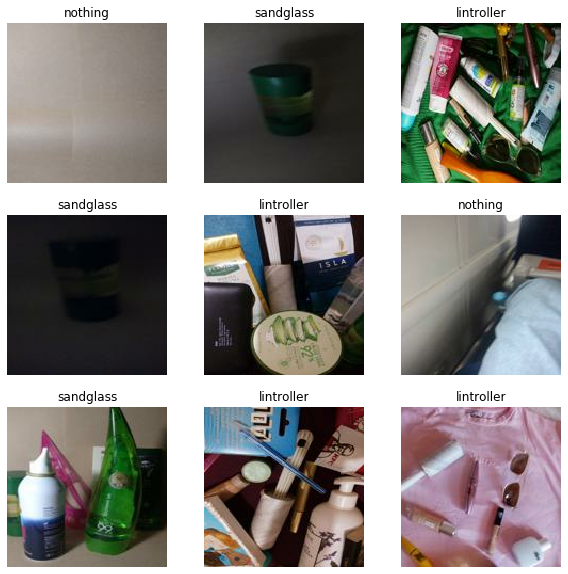

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [32]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(10, 150, 150, 3)
(10,)
